In [23]:
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from skimage import io
import os

import math
import requests

from queue import PriorityQueue

In [24]:
plotly.__version__
pio.renderers.default = "iframe"

In [25]:
np.__version__

'1.24.3'

In [26]:
np.random.seed(0)

In [27]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [28]:
%load_ext autoreload
%autoreload 2

from model import Bicycle, Map
from mppi import MPPI, MPPI_path_follower
from path_planner import a_star_planner
from sim import Simulation

import kmeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
torch.cuda.empty_cache() 

In [30]:
# avoid = []

# rect = [(20, 0, 80, 50),(20,51,80, 100) ]
# circle= []

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -4.)
# u_max = (10., 4.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

#start at 1-5, 45-55, angle -0

In [31]:
avoid = []

rect = [(0, 0, 100, 10),(0, 0, 10, 100), (0, 61, 85, 100), (20, 0, 100, 59),(95,0,100,100) ]
circle= [(20,40, 6), (10, 30, 6),(10, 50, 6)]

state_dim = 3
ctrl_dim = 2
u_min = (0., -4.)
u_max = (10., 4.)
step = .05
follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
horizon_depth = 64

# #start at (11-19, 11-19), angle math.pi/2

In [32]:
# avoid = []

# rect = [(0, 15, 47, 85), (53, 15, 100,85)]
# left_circles = [(47,20+x, 4) for x in range(0, 80, 20)]
# print(left_circles)
# right_circles = [(53,30+x, 4) for x in range(0, 60, 20)]
# circle= left_circles + right_circles

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -4.)
# u_max = (10., 4.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

# start at (45-55, 1-5), angle math.pi/2
#goal at 50, 90

In [33]:
def get_expert_controls(control_history, horizon_depth, ctrl_dim, interval_start = 0, interval_end = None, interval_step=2, dev="cpu"):
    if(interval_end is None):
        interval_end = len(control_history)-1
    first_rollout = interval_start
    last_rollout = interval_end-horizon_depth
    
    rollout_starts = range(first_rollout, last_rollout+1, interval_step)
    size = len(rollout_starts)
    
    expert_controls = torch.empty([size, horizon_depth, ctrl_dim], dtype = torch.float, device = dev)
    count = 0
    for i in rollout_starts:
        expert_controls[count,:,:] = torch.stack(control_history[i:i+horizon_depth])        
        count+=1
    return expert_controls

In [34]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
print(r+a)
print(t, r, a)
torch.cuda.empty_cache() 

214837248
25426132992 123731968 91105280


In [35]:
expert_controls = torch.tensor([],device = torch.device('cuda:0')) # used to reset expert_controls from constantly appending
a_star_sim = None
#
for i in range(2):
    for j in range(10):
        x = np.random.uniform(12, 18)
        y = np.random.uniform(12, 18)
        angle = np.random.uniform(5 *math.pi/12, 7 *math.pi/12)
            
        a_star_robot = Bicycle(x, y, angle, 0)
        goal = (90, 90, 3, 10)

        mppi_sample_center= torch.tensor([0., 0.])
        mppi_sample_covariance = torch.tensor([[4.,0.],[0., 1]])

        env = Map(goal_point = goal, avoidance_points=avoid, rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))
        a_star_map = Map(goal_point = (a_star_robot.x, a_star_robot.y,4,4), speed_weight = 0.1, avoidance_points=avoid, 
                         rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))

        def a_star_heuristic(state):     
            return env.terminal_state_cost_batch(state)

        a_star_plan = a_star_planner(a_star_robot, state_dim, ctrl_dim, u_min, u_max, 
                          env.get_obstacles_batch, env.get_distance_batch,
                         iterations = 50000, goal_point = env.goal_point, angle_density = 32, grid_interval = 0.4, goal_tolerance =0.1, 
                                           timestep = step, device=torch.device('cuda:0'))
        
        print (i, j, x, y, "plan ready")
        a_star_follower = MPPI_path_follower(a_star_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max, 
                          a_star_robot.dynamics_batch_horizon, a_star_map, 
                                             a_star_map.running_cost_batch_horizon, a_star_map.terminal_state_cost_batch, a_star_plan.path, 
                         num_samples = 8192, horizon = follow_depth, lambda_=.1, sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        print("expert demo started")
        
        a_star_sim = Simulation(a_star_robot, a_star_follower, a_star_map, goal_tolerance = 1, timestep = step)
        
        iter, goal_reached = a_star_sim.run(500, False, True, True, True, 
                                            write_rollout_start = 0, write_rollouts_num = 10, write_rate = 2)

        if not goal_reached:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            print("L")
        else:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            new_controls = get_expert_controls(a_star_robot.control_history, horizon_depth, ctrl_dim,interval_step = 2, dev = torch.device('cuda:0'))
            
            #expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = 7)
            expert_controls = torch.cat((expert_controls, new_controls), 0)
    
            #expert_means[:, :, -1] = -expert_means[:, :, -1]
            new_controls[:, :, -1] = -new_controls[:, :, -1]
            expert_controls = torch.cat((expert_controls, new_controls), 0)

        
        # losses = []
        # clusters = []
        
        # for num_cluster in range(1, 50, 5):
        #     expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = num_cluster)
        #     losses.append(loss)
        #     clusters.append(num_cluster)
        # plt.plot(clusters, losses)
        # plt.show()
            torch.cuda.empty_cache() 
            print(expert_controls.shape)



0 0 15.292881023563949 16.29113619823452 plan ready
expert demo started
torch.Size([222, 64, 2])
0 1 15.269299097981381 14.541928796033428 plan ready
expert demo started
torch.Size([446, 64, 2])
0 2 14.625523267576156 17.350638004692478 plan ready
expert demo started
torch.Size([664, 64, 2])
0 3 14.300649112954666 16.75035022849599 plan ready
expert demo started
torch.Size([884, 64, 2])
0 4 15.408267366563594 17.553579829755968 plan ready
expert demo started
torch.Size([1102, 64, 2])
0 5 12.522775798209244 12.121310384641955 plan ready
expert demo started
torch.Size([1332, 64, 2])
0 6 16.668940505699105 17.220072889480914 plan ready
expert demo started
torch.Size([1548, 64, 2])
0 7 16.794951385300344 14.76887617351759 plan ready
expert demo started
torch.Size([1770, 64, 2])
0 8 12.709646555213599 15.839526127965144 plan ready
expert demo started
L
0 9 17.668013502297505 15.13108993050043 plan ready
expert demo started
torch.Size([1992, 64, 2])
1 0 13.587333672627762 16.6454021366053 pl

In [36]:
# a_star_sim.draw_explored(a_star_plan.path, False)

# a_star_sim.display_run()
# a_star_sim.display_history()

torch.cuda.empty_cache() 

del a_star_planner
del a_star_sim
del a_star_map

/home/s-hliao/Documents/mppi-plt-sim/mppi.py:154: SyntaxWarning:

"is" with a literal. Did you mean "=="?

/home/s-hliao/Documents/mppi-plt-sim/mppi.py:320: SyntaxWarning:

"is" with a literal. Did you mean "=="?



In [37]:
%who

Bicycle	 MPPI	 MPPI_path_follower	 Map	 MultivariateNormal	 PriorityQueue	 Simulation	 a	 a_star_follower	 
a_star_heuristic	 a_star_plan	 a_star_robot	 angle	 available_gpus	 avoid	 circle	 clusters	 ctrl_dim	 
env	 expert_controls	 expert_means	 expert_sample_covariance	 follow_depth	 get_expert_controls	 go	 goal	 goal_reached	 
horizon_depth	 i	 io	 iter	 j	 kmeans	 loss	 losses	 math	 
mpimg	 mppi_goal	 mppi_map	 mppi_robot	 mppi_sample_center	 mppi_sample_covariance	 new_controls	 np	 num_cluster	 
os	 pio	 plotly	 plt	 px	 r	 rect	 requests	 state_dim	 
step	 success	 t	 torch	 total	 total_it	 u_max	 u_min	 x	 
y	 


In [40]:
losses = []
clusters = []


for num_cluster in range(1, 40, 2):
    expert_means,  loss = kmeans.k_means_segment(expert_controls, k = num_cluster)
    losses.append(loss)
    clusters.append(num_cluster)
    print(num_cluster)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39


[149618.9375, 145701.09375, 143529.9375, 141797.953125, 140721.875, 139579.28125, 138852.875, 138017.46875, 137191.9375, 136629.921875, 135806.046875, 135468.671875, 134753.15625, 134419.90625, 133861.8125, 133052.109375, 132621.3125, 132267.359375, 132044.609375, 131894.546875]


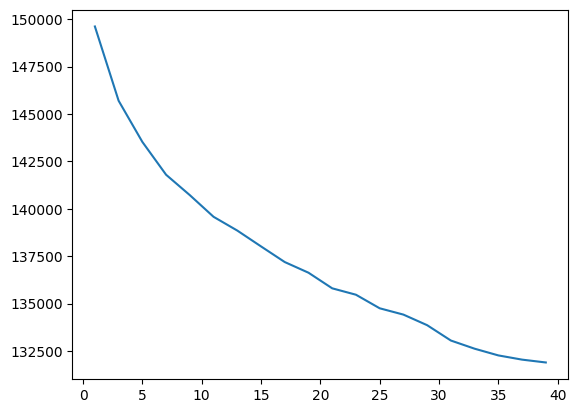

In [39]:
print(losses)
plt.plot(clusters, losses)
plt.show()

In [19]:
num_clusters = 13
expert_means, assigned_to_center, loss = kmeans.k_means_segment(expert_controls, k = num_clusters)
print(assigned_to_center, expert_means.shape)


[1061, 1162, 1277, 1174, 1217, 861, 1127, 1206, 795, 1126, 1142, 1165, 1181] torch.Size([13, 64, 2])


In [41]:
use_expert_controls = False
samples = 2048
controls = None

expert_samples = [50 for i in range(13)]

if use_expert_controls:
    if expert_samples is not None:
        samples = samples
        controls = expert_means
    else:
        samples = samples - expert_controls.shape[0]
        controls = expert_controls
    
if(samples <0):
    print("too many expert rollouts")

In [ ]:

mppi_sample_center= torch.tensor([0., 0.])
mppi_sample_covariance = torch.tensor([[16.,0.],[0., 1]])
expert_sample_covariance = torch.tensor([[16.,0.],[0., .1]])
# note: if these parameters are changed, the a-star ones should be changed to match

# changes to 8 clusters

success = 0.
total = 0.
total_it = 0.

for i in range(10):
    for j in range(10):
        x = np.random.uniform(12, 18)
        y = np.random.uniform(12, 18)
        angle = np.random.uniform(5 *math.pi/12, 7 *math.pi/12)

        if(angle < 0):
            angle += 2* math.pi

        mppi_robot = Bicycle(x, y, angle, 0)
        mppi_goal = (90, 90, 1, 10)

        mppi_map = Map(goal_point = mppi_goal, avoidance_points=avoid, 
                       rect_obstacles=rect,circle_obstacles=circle, speed_weight = 0.1, device = torch.device('cuda:0'))
        mppi_controller = MPPI(mppi_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max,
                          mppi_robot.dynamics_batch_horizon, mppi_map.running_cost_batch_horizon, mppi_map.terminal_state_cost_batch,
                               expert_rollouts = controls, expert_samples = expert_samples,
                          num_samples = samples, noise_expert = expert_sample_covariance,
                               horizon = horizon_depth, lambda_=1,sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        mppi_sim = Simulation(mppi_robot, mppi_controller, mppi_map, timestep = step, goal_tolerance = 2)

        iterations, completed = mppi_sim.run(iterations=400, draw_obstacles = False, write_snapshots =False, 
              write_rollouts=True, write_controls = True, write_rollout_start = 0, write_rollouts_num = 6,write_rate = 2)
        
        

        if completed:
            success+=1
            total_it += iterations
        #else:
            #mppi_sim.display_history()
        total+=1
        
        
        print(i, j, completed, iterations)
        
print(success/total)
if success > 0:
    print(total_it/success)

